In [1]:
import os
import random
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
from torchvision import models
import torch.nn as nn
import koreanize_matplotlib


def load_and_preprocess_image(image_path, transform):
    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image)
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

In [3]:
class_names = ['페미닌', '로맨틱', '리조트', '모던', '스포티', '톰보이', '매니시', '젠더리스']

In [8]:
def predict_and_display_images(model, df, transform, device, class_names, num_images=30):
    # 모델을 평가 모드로 설정
    model.eval()

    # 랜덤하게 선택된 이미지 파일 가져오기
    selected_df = df.sample(n=num_images)

    # 이미지와 예측 결과를 저장할 리스트
    images = []
    predictions = []
    true_labels = []

    for index, row in selected_df.iterrows():
        image_path = row['Image Path']
        true_label = [class_names[i] for i, val in enumerate(row[1:-1]) if val == 1]
        image = load_and_preprocess_image(image_path, transform)
        if image is not None:
            images.append(image)
            true_labels.append(true_label)
            image = image.unsqueeze(0).to(device)  # 배치 차원 추가 및 디바이스로 이동
            with torch.no_grad():
                outputs = model(image)
                outputs = torch.sigmoid(outputs)
            predictions.append(outputs.cpu().numpy().flatten())

    # 이미지와 예측 결과 출력
    fig, axs = plt.subplots(num_images // 5, 5, figsize=(20, num_images // 5 * 4))
    for i, (img, pred, true_label) in enumerate(zip(images, predictions, true_labels)):
        ax = axs[i // 5, i % 5]
        img = transforms.ToPILImage()(img.cpu())
        ax.imshow(img)
        ax.axis('off')

        # 상위 2개의 예측 클래스 선택
        top2_indices = pred.argsort()[-2:][::-1]
        pred_text = ", ".join([f"{class_names[j]}: {pred[j]:.2f}" for j in top2_indices])
        true_label_text = ", ".join(true_label)
        ax.set_title(f'True: {true_label_text}\nPred: {pred_text}', fontsize=8)

    plt.tight_layout()
    plt.show()


In [9]:
import pandas as pd
# 데이터프레임 로드

def read_df():
    df_raw = pd.read_csv('multi_label_dataset_cut.csv')

    df = df_raw.copy()
    # 이미지 디렉토리 설정
    image_dir = "../data"

    # 데이터프레임 확인

    df = df.drop(['Image Filename'],axis=1)
    df = df.drop(['None'],axis=1)
    # 이미지 경로 생성 함수
    def create_image_paths(df, column_name, base_path='../cut_datas'):
        # 이미지 경로를 저장할 새로운 열 추가
        df['Image Path'] = df[column_name].apply(lambda x: os.path.join(base_path, f'{x}.jpg'))
        return df

    # 이미지 경로 생성
    df = create_image_paths(df, 'Image ID')
    df = df.drop(['Unnamed: 0','Image ID'],axis=1)
    df = df.drop(['스트리트'],axis=1)
    df.head()
    return df

In [10]:
def main():
    # GPU 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 모델 생성 및 전이학습
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False


    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),  # Batch Normalization 추가
    nn.Dropout(0.4),  # Dropout 확률 증가
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),  # Batch Normalization 추가
    nn.Dropout(0.4),  # Dropout 확률 증가
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),  # Batch Normalization 추가
    nn.Dropout(0.4),  # Dropout 확률 증가
    nn.Linear(256, len(class_names))  # len(label_columns)는 클래스 수
    )

    model = model.to(device)

    # 학습된 모델 로드
    model.load_state_dict(torch.load('val_acc_best_model_v7.pth'))
    
    # 이미지 변환 설정
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # 데이터프레임 로드
    df = read_df()

    # 임의의 이미지를 예측하고 출력
    predict_and_display_images(model, df, transform, device, class_names)

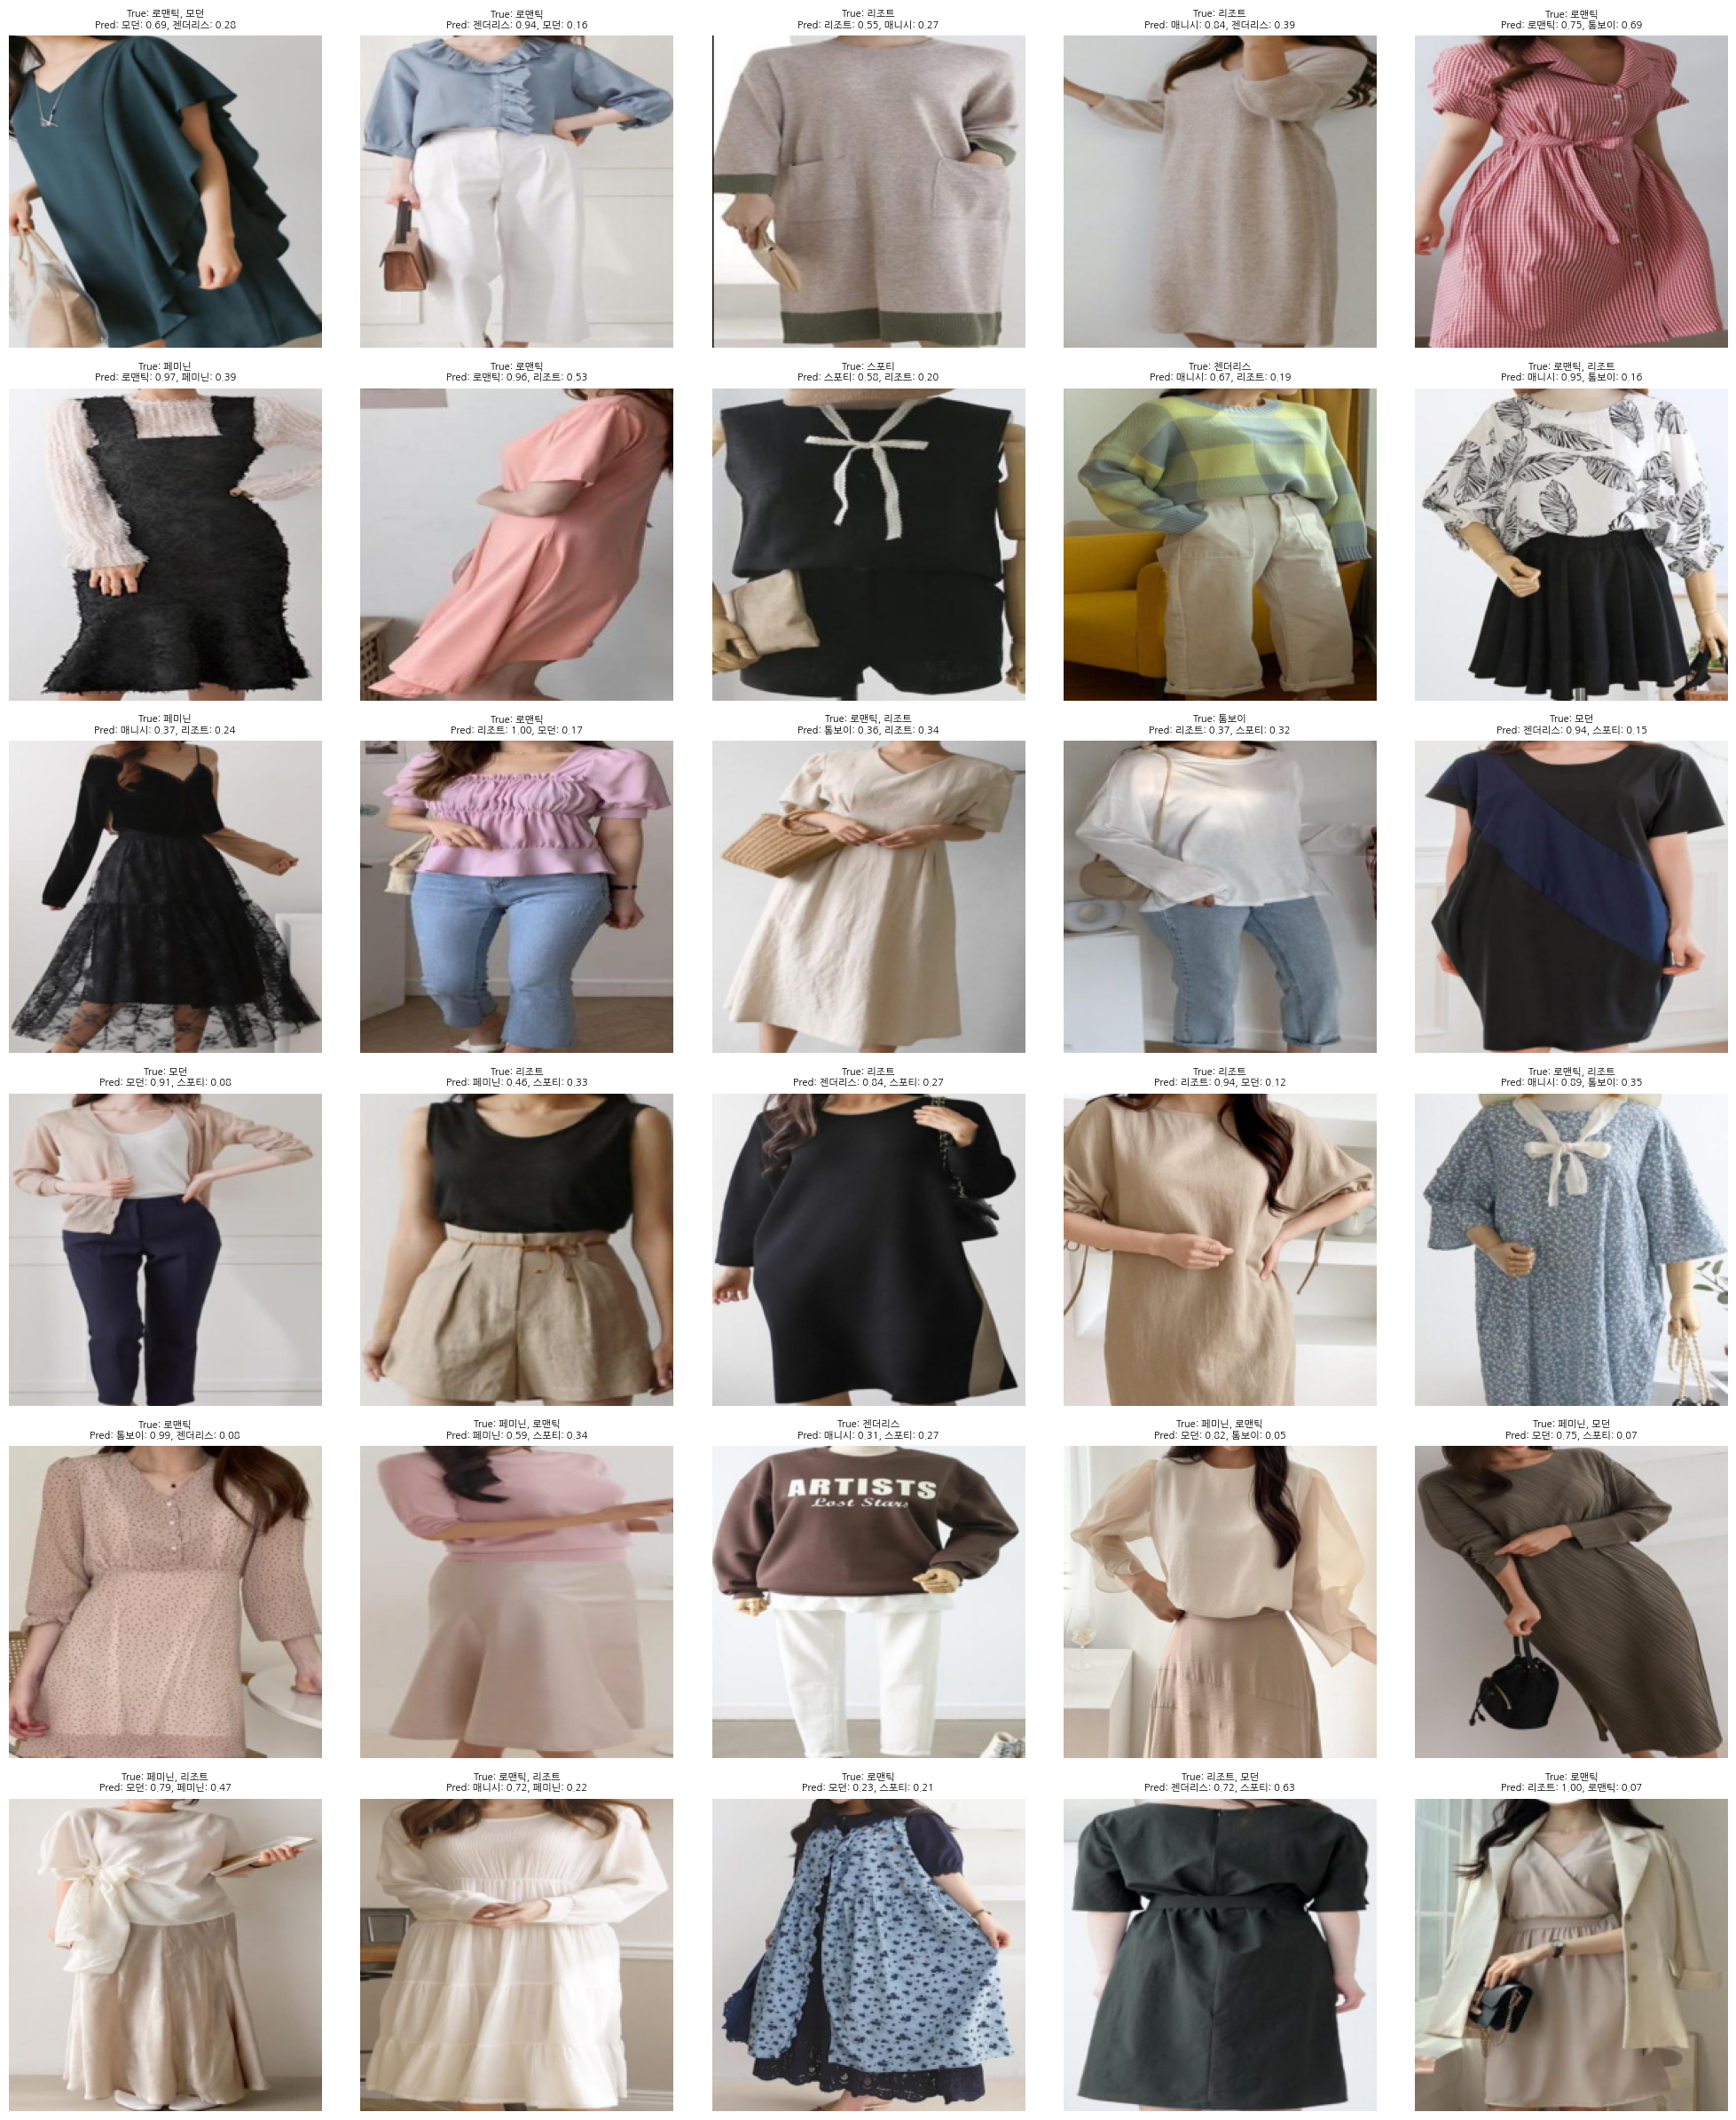

In [11]:
main()